# What factors lead developers to stay longer in their current jobs ?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from data_helpers import transform_coding_experience
from data_helpers import filter_employed_developers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(color_codes=True)

## Loading data

In [2]:
df = pd.read_csv('data/stackoverflow-2019/survey_results_public.csv')
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [3]:
df.shape

(88883, 85)

In [4]:
df2 = pd.read_csv('data/stackoverflow-2019/survey_results_schema.csv')
df2.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,MainBranch,Which of the following options best describes ...
2,Hobbyist,Do you code as a hobby?
3,OpenSourcer,How often do you contribute to open source?
4,OpenSource,How do you feel about the quality of open sour...


## Part I: Does the job role lead the developers stay longer in the job?

First, we need to find in the data how can we calculate how long each professional stays in a job.

In [5]:
df2[df2.QuestionText == 'When was the last time that you took a job with a new employer?']['Column'].values[0]

'LastHireDate'

In [6]:
df.LastHireDate.value_counts()

Less than a year ago                                    25844
1-2 years ago                                           21365
More than 4 years ago                                   14594
3-4 years ago                                           11597
NA - I am an independent contractor or self employed     3426
I've never had a job                                     3028
Name: LastHireDate, dtype: int64

In [7]:
df2[df2.QuestionText == 'Which of the following best describes your current employment status?']['Column'].values[0]

'Employment'

In [8]:
df.Employment.value_counts()

Employed full-time                                      64440
Independent contractor, freelancer, or self-employed     8511
Not employed, but looking for work                       5600
Employed part-time                                       4469
Not employed, and not looking for work                   3803
Retired                                                   358
Name: Employment, dtype: int64

As we are interested only in analyzing professional who currently work for a employer, we are going to filter other professionals out of our data set.

In [9]:
p1_df = df.copy()
p1_df = filter_employed_developers(p1_df)
p1_df.shape

(68063, 85)

Now, we also have to find how to extract different job titles from the interviewed professionals.

In [10]:
df2[df2.QuestionText == 'Which of the following describe you? Please select all that apply.']['Column'].values[0]

'DevType'

In [11]:
p1_df.DevType.value_counts().head()

Developer, full-stack                                             7550
Developer, back-end                                               4550
Developer, back-end;Developer, front-end;Developer, full-stack    2072
Developer, front-end                                              1961
Developer, mobile                                                 1938
Name: DevType, dtype: int64

We definitely started to understand our data! We have information about how long professionals are in their current jobs and we can analyze it by job role. However, first, we need to transform the data to use it properly.

### Data preparation

In [12]:
p1_df['LastHireDate'].value_counts()

Less than a year ago     22378
1-2 years ago            19080
More than 4 years ago    13453
3-4 years ago            10531
Name: LastHireDate, dtype: int64

Let's remove rows when `LastHireDate` is NA:

In [13]:
p1_df = p1_df.dropna(subset=['LastHireDate'])

Then, we need to clean `DevType`. As a professional can have multiple job roles and we are interested in analyzing `LastHireDate` per job role, we will attribute `LastHireDate` to each job role defined by the professional.

In [14]:
p1_df.loc[:,'JobRole'] = p1_df['DevType'].apply(lambda x: str(x).split(';'))
p1_df = p1_df.explode('JobRole')
p1_df = p1_df[p1_df.JobRole != 'nan']
p1_df[['JobRole', 'LastHireDate']].head()

,JobRole,LastHireDate
2,Designer,1-2 years ago
2,"Developer, back-end",1-2 years ago
2,"Developer, front-end",1-2 years ago
2,"Developer, full-stack",1-2 years ago
3,"Developer, full-stack",Less than a year ago


Let's also prepared `YearsCode` variable:

In [15]:
p1_df['YearsCodePro'] = p1_df['YearsCodePro'].fillna(value=-1)
p1_df.loc[:,'YearsCodePro'] = p1_df['YearsCodePro'].apply(transform_coding_experience)

In [16]:
legend = ['Less than a year ago', '1-2 years ago', '3-4 years ago', 'More than 4 years ago']

### Answering the question

For each job role, we want to analyze the distribution of `LastHireDate` for that job role.

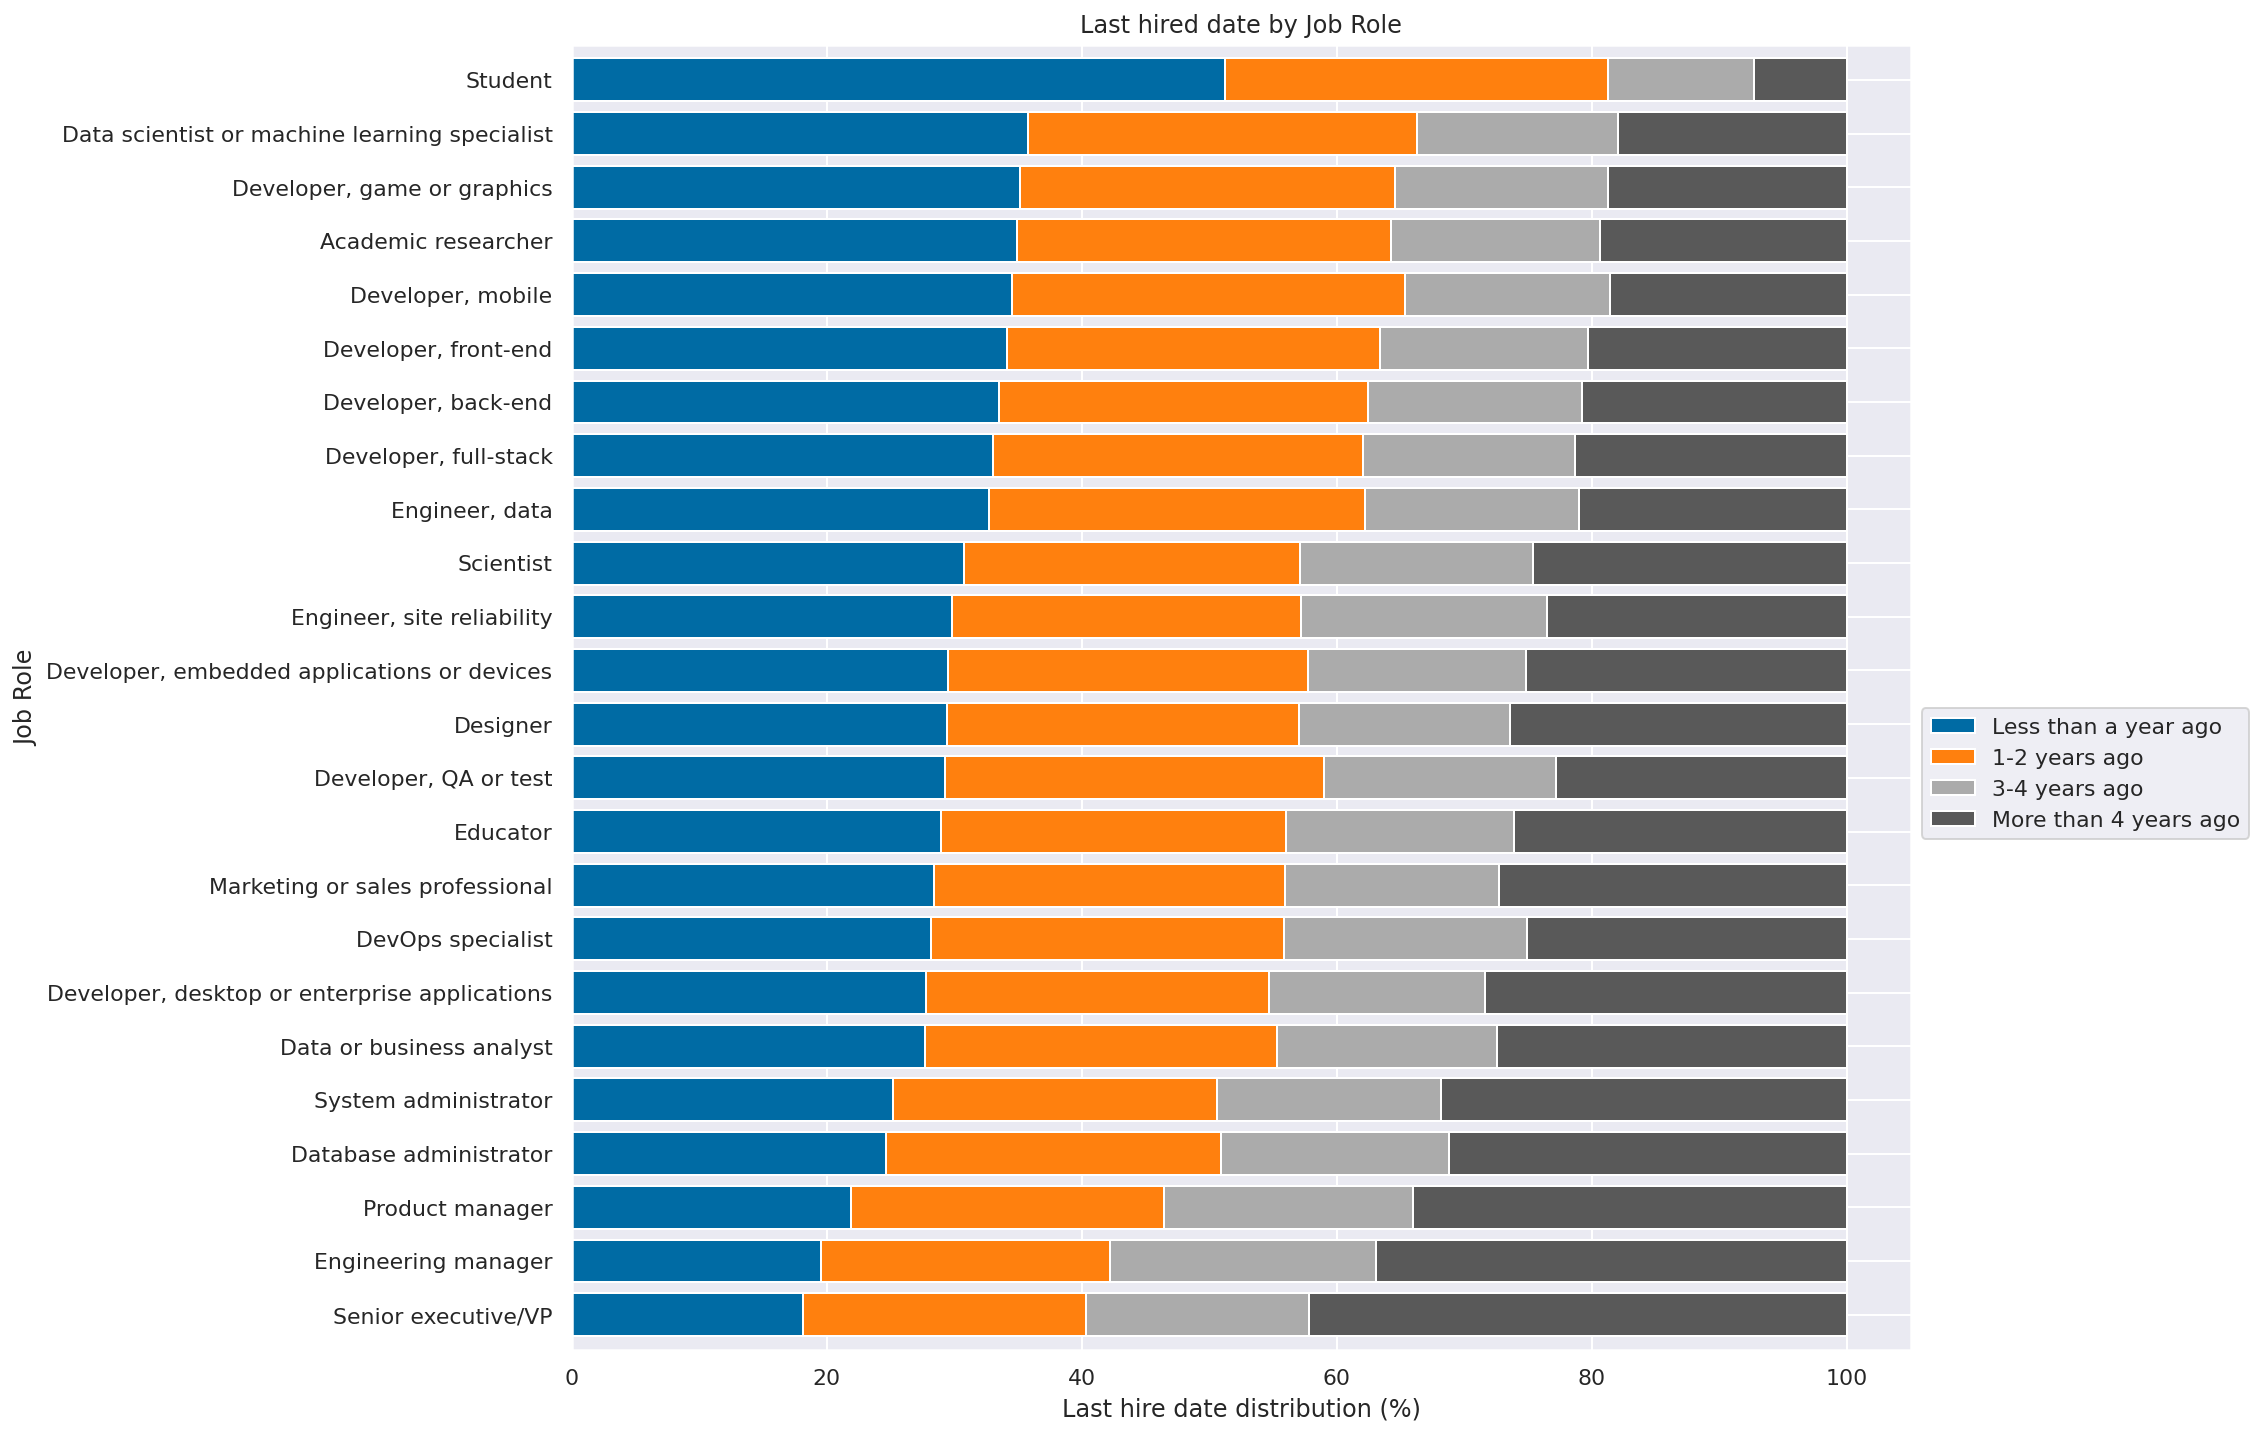

In [17]:
plt.style.use('tableau-colorblind10')

p1_plot = (p1_df.groupby(['JobRole', 'LastHireDate']).size()  / p1_df.groupby(['JobRole']).size() * 100).unstack()[legend]\
        .sort_values(by=legend, ascending=True)

p1_plot.plot(kind='barh', stacked=True, figsize=(12, 12), align='center', width=0.8)\
       .legend(bbox_to_anchor=(1.0, 0.5));

plt.title('Last hired date by Job Role');
plt.xlabel('Last hire date distribution (%)');
plt.ylabel('Job Role');

plt.style.use('default')

In [18]:
p1_plot

LastHireDate,Less than a year ago,1-2 years ago,3-4 years ago,More than 4 years ago
JobRole,,,,
Senior executive/VP,18.158996,22.175732,17.489540,42.175732
Engineering manager,19.543465,22.701689,20.856785,36.898061
Product manager,21.925926,24.518519,19.518519,34.037037
Database administrator,24.630334,26.292072,17.884805,31.192790
System administrator,25.242868,25.397070,17.548188,31.811874
Data or business analyst,27.703420,27.597196,17.272148,27.427236
"Developer, desktop or enterprise applications",27.818726,26.833540,16.930599,28.417135
DevOps specialist,28.175457,27.691066,19.052745,25.080732
Marketing or sales professional,28.440367,27.522936,16.743119,27.293578


#### Conclusions

* There are 4 job roles where most of professionals are 3 years or more in their current jobs:

  * Senior executive/VP
  * Engineering manager
  * Product manager
  * Database administrator


* It seems professionals working in management positions stay longer in their jobs. A hypothesis is those professionals developed their entire careers in the same company. That is something we will investigate in the second part of this analysis. 


* It is expected that most of  Students are `Less than 1 year` in their current jobs

Regarding the remaining job roles, we observe turn-over may be high as mostly of the interviewed professionals are less than 1 year in their jobs. Or maybe these professionals may be in the beginning of their careers. Let's drill our analysis down in more variables for each job role. Let's get started by years coding (experience).

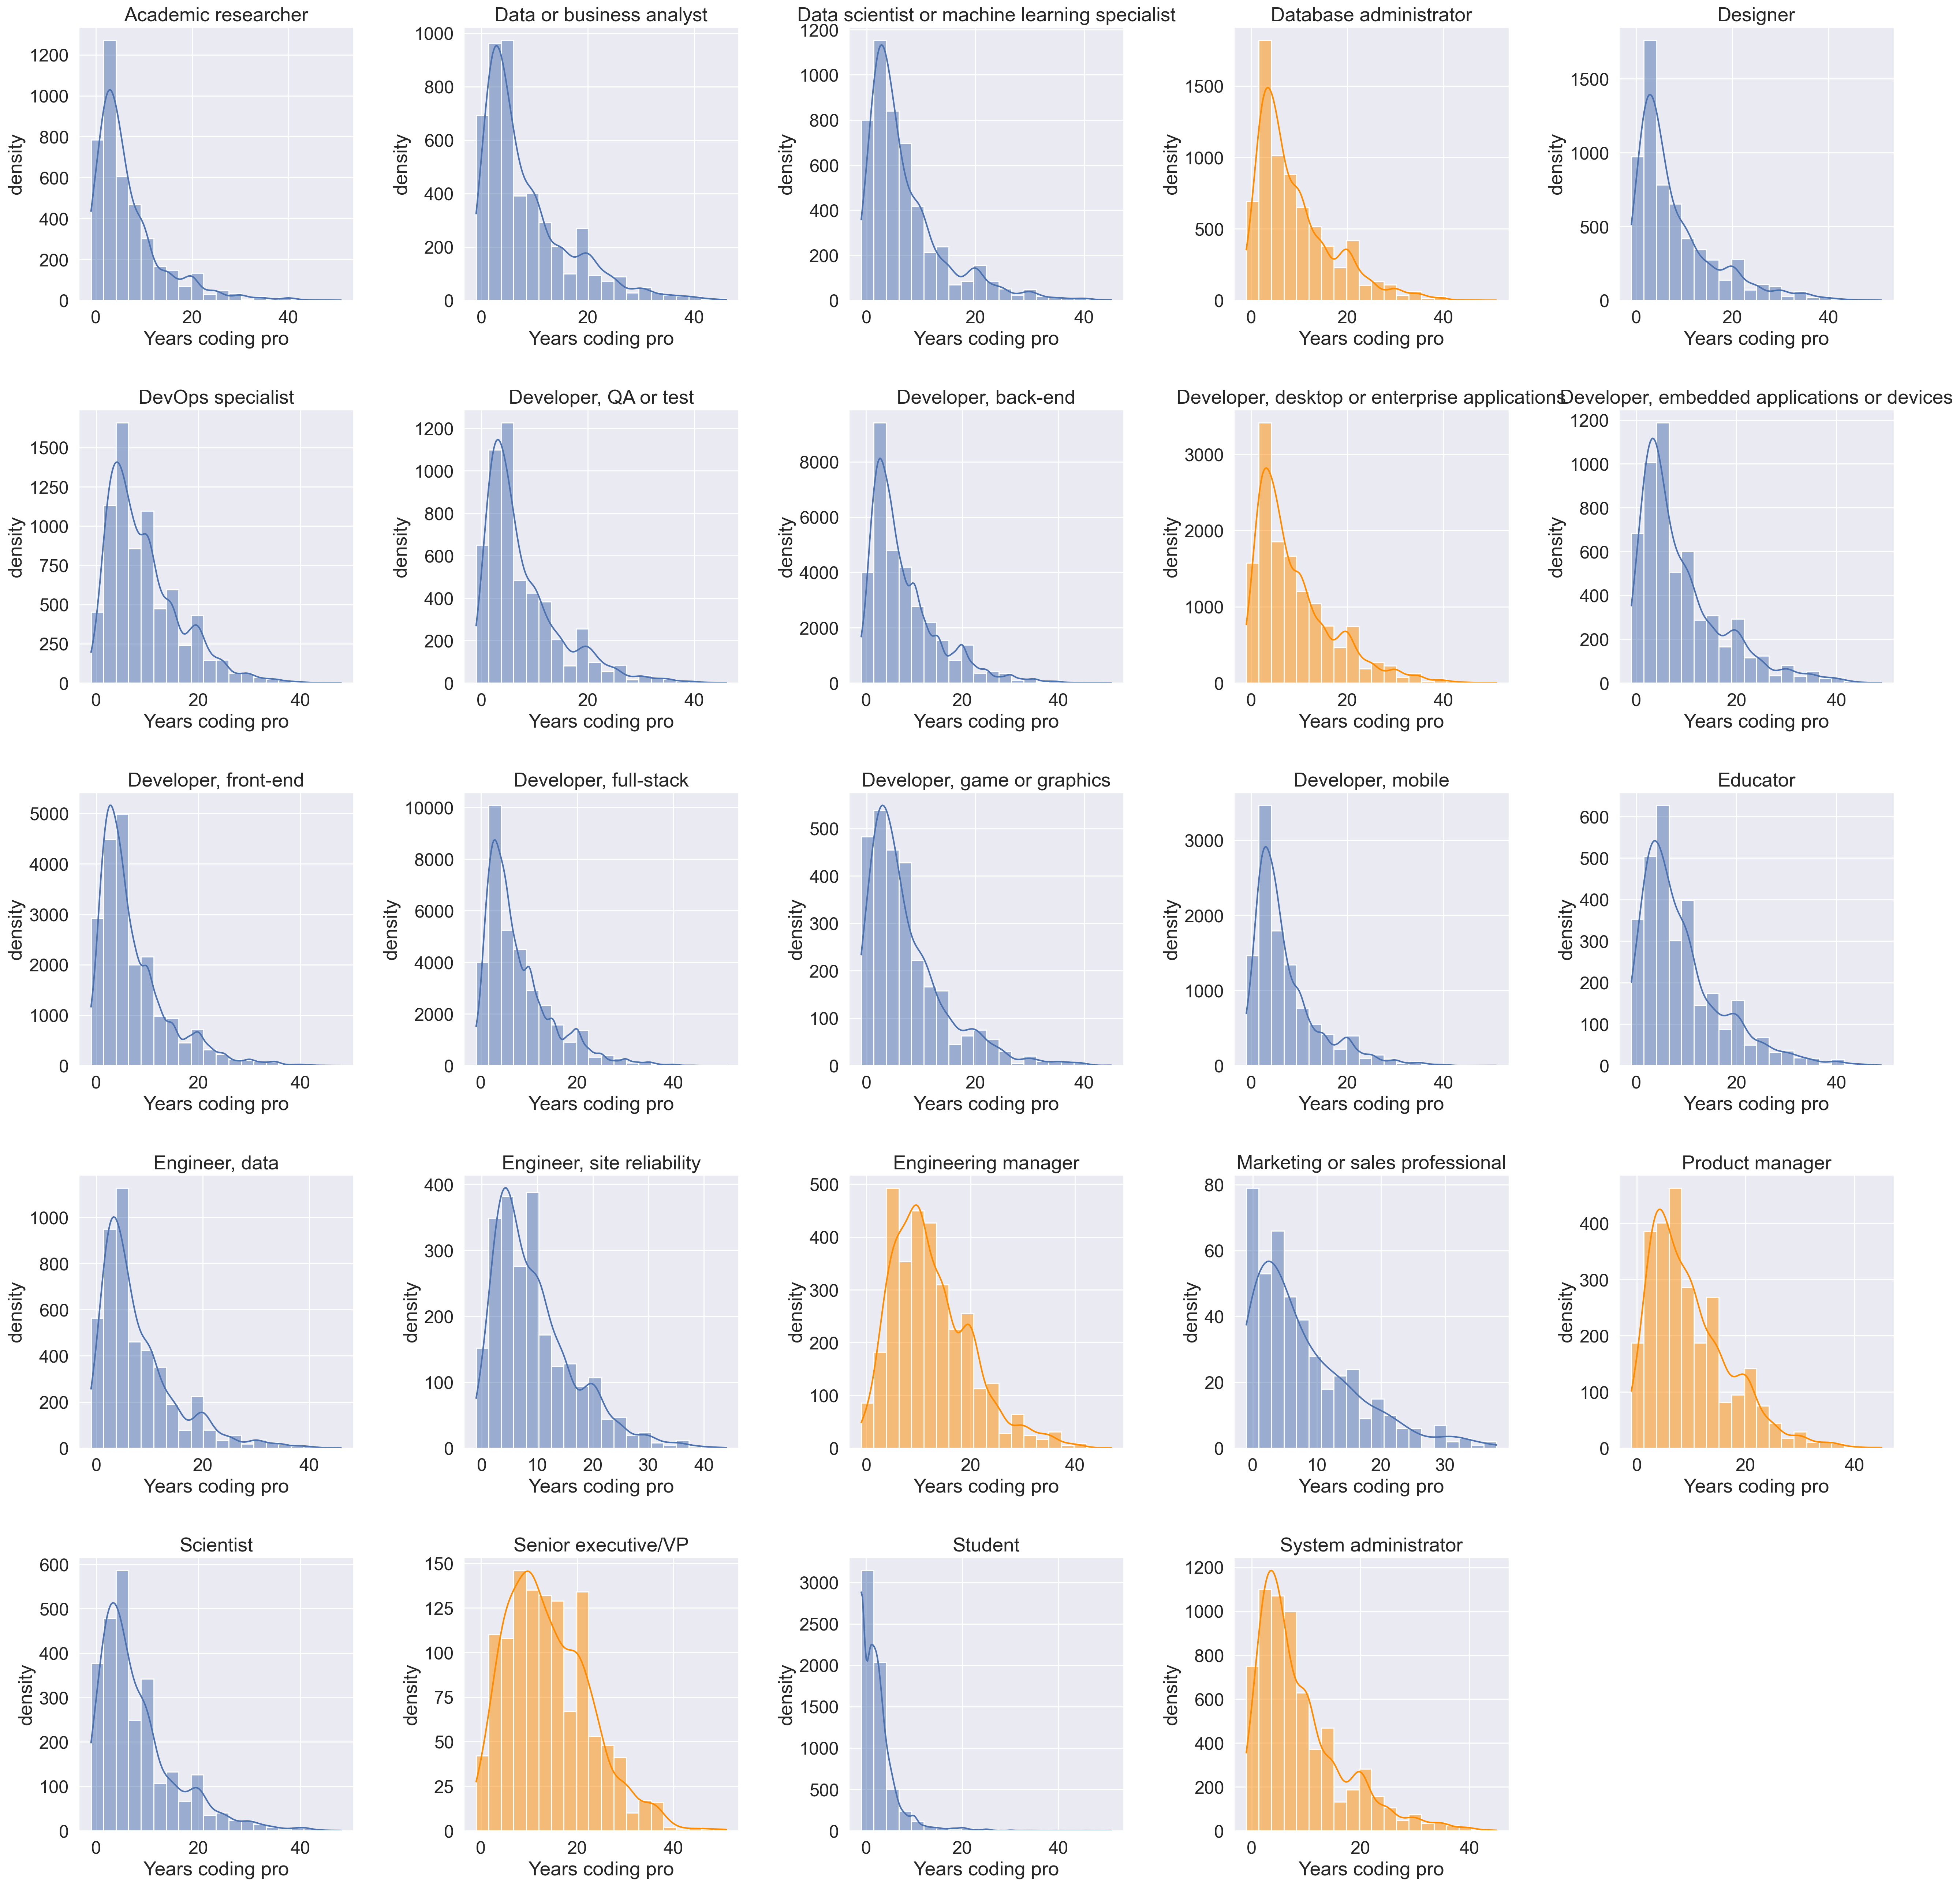

In [19]:
sns.set(font_scale=1.6)

job_roles = sorted(p1_df.JobRole.unique())

fig = plt.figure(figsize=(32, 32))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

top_roles = ['System administrator', 'Database administrator', 'Senior executive/VP', 'Product manager', 
             'Engineering manager', 'Developer, desktop or enterprise applications']

for idx, job_role in enumerate(job_roles):
    ax = fig.add_subplot(5, 5, idx + 1)
    
    data = p1_df[p1_df.JobRole == job_role][['YearsCodePro']]
    
    if job_role in top_roles:
        sns.histplot(data=data, bins=20, ax=ax, x='YearsCodePro', color='darkorange', kde=True)
    else:
        sns.histplot(data=data, bins=20, ax=ax, x='YearsCodePro', kde=True)
      
    ax.set(xlabel='Years coding pro', ylabel='density')
    ax.set_title(job_role)
    
plt.show();

sns.set(font_scale=1)

#### Conclusions

* `YearsCoding` distribution is very similar for job roles where most of professionals are **less than 1 year** in their jobs.
* For professionals who are longer in their jobs (orange plots), we can observe, for management roles, the interviewed professionals are more experienced.

## Part II: Wishing to become a manager leads developers stay longer in a job ?

In [20]:
df2[df2.QuestionText == 'Do you want to become a manager yourself in the future?']['Column'].values[0]

'MgrWant'

In [21]:
df['MgrWant'].value_counts()

Not sure                  22276
No                        20383
Yes                       15565
I am already a manager     3008
Name: MgrWant, dtype: int64

In [22]:
p2_df = df.copy()
p2_df = filter_employed_developers(p2_df)
p2_df = p2_df.dropna(subset=['LastHireDate', 'MgrWant'])
p2_df.shape

(58980, 85)

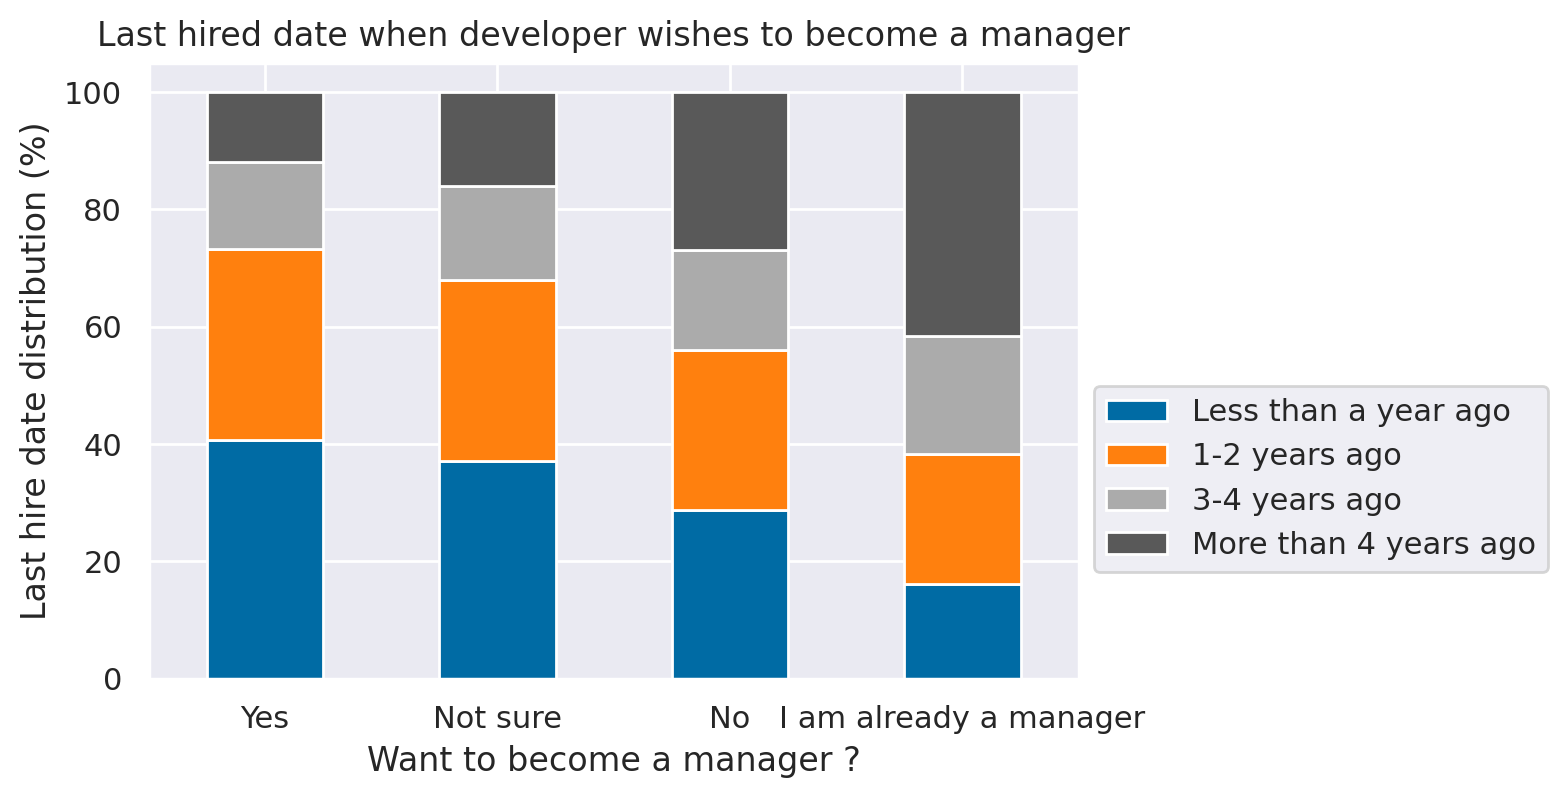

In [23]:
plt.style.use('tableau-colorblind10')


p2_plot = (p2_df.groupby(['MgrWant', 'LastHireDate']).size()  / p2_df.groupby(['MgrWant']).size() * 100).unstack()[legend]\
        .sort_values(by='MgrWant', ascending=False)

p2_plot.plot(kind='bar', stacked=True, figsize=(6, 4)
      ).legend(bbox_to_anchor=(1.0, 0.5));

plt.title('Last hired date when developer wishes to become a manager');
plt.xlabel('Want to become a manager ?');
plt.ylabel('Last hire date distribution (%)');
plt.xticks(rotation=0)

plt.style.use('default')

In [24]:
p2_plot

LastHireDate,Less than a year ago,1-2 years ago,3-4 years ago,More than 4 years ago
MgrWant,,,,
Yes,40.591398,32.694892,14.744624,11.969086
Not sure,37.004853,30.940606,15.960250,16.094292
No,28.735110,27.251161,16.974561,27.039168
I am already a manager,16.057294,22.125895,20.128157,41.688654


#### Conclusions

We had quite surprising findings in this last plot:

* Clearly, the data indicates that developers who does **NOT** `wish to become a manager` are longer in their current jobs. More than that, around 27% of are  **more than 4 years** in their current jobs.

* About 41% of those who `wish to become a manager` are **Less than a year** in their current jobs

* As observed in the Part I of this analysis, most of developers (around 62%) who are already managers are at least 3 years in their current jobs.